In [1]:
#!pip install pyabc
import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   Distance)
from pyabc.visualization import plot_kde_2d, plot_data_callback
import matplotlib.pyplot as plt
import os
import tempfile
import numpy as np
#import scipy as sp
from scipy.integrate import odeint
import math
import seaborn as sns
import pandas as pd
#pyabc.settings.set_figure_params('pyabc')  # for beautified plots
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test4.db"))



# Plot the data

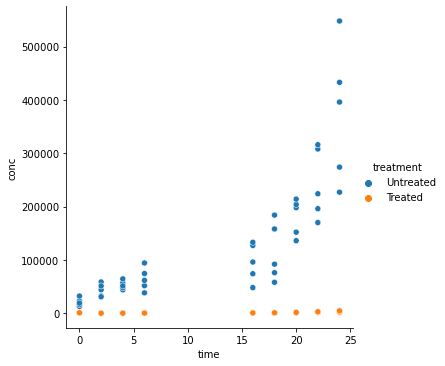

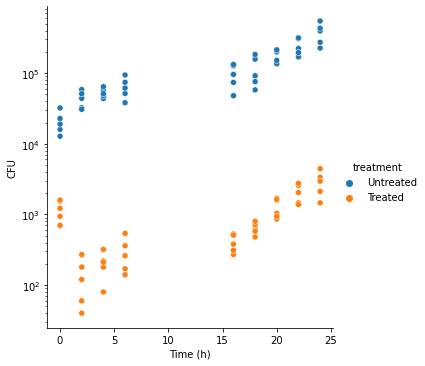

In [2]:
#Import gerba.data.20200302.csv
gerba_data = pd.read_csv('../Data/gerba.data.20200302.csv')
#using seaborn plot conc vs time and colour by treatment on log scale and add linear regression
sns.relplot(x='time', y='conc', hue='treatment', data=gerba_data, ci=None, palette='tab10') 
g=sns.relplot(x='time', y='conc', hue='treatment', data=gerba_data)
g.set(yscale="log")
_ = g.set(xlabel="Time (h)", ylabel="CFU")

Fit the untreated hand data from 0h-6h from group 1 to estimate r and l. Could use 16-24h from group 2.

In [3]:
#Here we defien the ODE model (1) $ y'=(yl+r)(1-y)$
def ode_model(contamination,t,r,l):
    Contamination = contamination;
    #return((Contamination*l+r)*(1-Contamination)-d*math.exp(-g*t))
    return((Contamination*l+r)) #r*(1-Contamination)-d*math.exp(-g*t)*Contamination

#Here we create the input parameters and extract only specific time-points
def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
    precision=5000
    tmax = 24
    time_space = np.linspace(0,tmax,precision+1)#precision+1?
    sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["l"]))
    #num_at_0=sim[int(precision*0.1/50.0)]
    #num_at_1=sim[int(precision*1/tmax)]
    num_at_2=sim[int(precision*2/tmax)]
    num_at_4=sim[int(precision*4/tmax)]
    num_at_6=sim[int(precision*6/tmax)]
    # num_at_8=sim[int(precision*8/tmax)]
    num_at_16=sim[int(precision*16/tmax)]
    num_at_18=sim[int(precision*18/tmax)]
    num_at_20=sim[int(precision*20/tmax)]
    num_at_22=sim[int(precision*22/tmax)]
    num_at_24=sim[int(precision*24/tmax)]
    return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]}
    # return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# def model(Contamination,t,r,l): #this is the analytical solution to (yl+r)(1-y)
#     precision=5000
#     tmax = 6
#     time_space = np.linspace(0,tmax,precision+1)
#     sim=-1*(l*Contamination^3)/3 + (l/2 - r/2)*Contamination^2 + r*Contamination
#     num_at_2=sim[int(precision*2/tmax)]
#     num_at_4=sim[int(precision*4/tmax)]
#     num_at_6=sim[int(precision*6/tmax)]
#     return(-1*(l*Contamination^3)/3 + (l/2 - r/2)*Contamination^2 + r*Contamination)



In [4]:
# from scipy.integrate import odeint
# import numpy as np
# def ode_model(contamination,t,r,l):
#     Contamination = contamination;
#     return((Contamination*l+r)*(1-Contamination))

# #Here we create the input parameters and extract only specific time-points
# def deterministic_run(parameters):#precision,initial_contamination,r,C,d,g):
#     precision=5000
#     tmax = 6
#     time_space = np.linspace(0,tmax,precision+1)#precision+1?
#     sim=odeint(ode_model,initial_contamination,time_space,args=(parameters["r"],parameters["l"]))
#     #num_at_0=sim[int(precision*0.1/50.0)]
#     #num_at_1=sim[int(precision*1/tmax)]
#     num_at_2=sim[int(precision*2/tmax)]
#     num_at_4=sim[int(precision*4/tmax)]
#     num_at_6=sim[int(precision*6/tmax)]
#     # num_at_8=sim[int(precision*8/tmax)]
#     #num_at_16=sim[int(precision*16/tmax)]
#     #num_at_18=sim[int(precision*18/tmax)]
#     #num_at_20=sim[int(precision*20/tmax)]
#     #num_at_22=sim[int(precision*22/tmax)]
#     #num_at_24=sim[int(precision*24/tmax)]
#     #return{"Contamination":[num_at_2,num_at_4,num_at_6,num_at_16,num_at_18,num_at_20,num_at_22,num_at_24]}
#     return{"Contamination":[num_at_2,num_at_4,num_at_6]}

# #print(deterministic_run({"r":0.1,"l":0.1}))
# odeint(ode_model,20560,np.linspace(0,6,5000+1),args=(0.1,0.2))




# Define the parameter priors

We choose some examples to see how well it works.

In [5]:
parameter_prior = Distribution(r=RV("uniform", 20, 100.0),
                               l=RV("uniform", 0.0, 4.0))

#parameter_prior.get_parameter_names()

# Define the distance function
This currently is a absolute distances between the two points divided by the standard deviation at each point. Could use Manhattan distance.

In [6]:
def distance(simulation, data):
    return np.absolute((data["Contamination"] - simulation["Contamination"])).sum()

# Set up the ABC SMC 


In [7]:
# We plug all the ABC options together and use an adaptive population size
from pyabc.populationstrategy import AdaptivePopulationSize
# from pyabc.epsilon import epsilon
# acceptor = pyabc.StochasticAcceptor()
# kernel = pyabc.IndependentNormalKernel(var=0.2**2)
# eps = pyabc.Temperature()


abc = ABCSMC(
    models=deterministic_run,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=AdaptivePopulationSize(1000, 0.15),
    #population_size=1000,
    transitions=LocalTransition(k_fraction=0.3),
    #eps=MedianEpsilon(500, median_multiplier=0.7),
)

# abc = ABCSMC(
#     models=deterministic_run,
#     parameter_priors=parameter_prior,
#     #population_size=AdaptivePopulationSize(1000, 0.15),
#     # kernel=pyabc.IndependentNormalKernel(var=0.2**2), 
#     eps=epsilon.TemperatureBase(), 
#     acceptor=pyabc.StochasticAcceptor(),
#     population_size=1000,
#     #transitions=LocalTransition(k_fraction=0.3),
#     # eps=MedianEpsilon(500, median_multiplier=0.7),
# )

ABC.Sampler INFO: Parallelize sampling on 8 processes.


# Setting the observed data

In [8]:
# y_observed is the important piece here: our actual observation.
initial_contamination=20560

#Assign y_observed to the ABCSMC object
measurement_data =np.array([43400,52880,64000,95600,113600,180800,242800,375600])#  np.array([134.0,202.0,294.0]) #y_observed #
s=np.array([11958,8100,21479,35767,54542,34543,66055,128294])#np.array([93.70165,86.13942,162.11107])#,116.61904,123.61230,396.88789,628.87201,1147.13556]) y_observed_sd #
precision=5000
measurement_times = np.array([2,4,6,16,18,20,22,24]) #np.array([2,4,6]) #np.array([2,4,6,16,18,20,22,24]) #


#This sets up the database and includes the measurement data and standard deviation
history = abc.new(db_path, {"Contamination": measurement_data,"sd":s})

ABC.History INFO: Start <ABCSMC id=31, start_time=2022-04-14 13:04:10>


# Running the ABC

In [9]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.1, max_nr_populations=20)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.06769861e+26.
ABC INFO: Accepted: 1000 / 2048 = 4.8828e-01, ESS: 1.0000e+03.
ABC.Adaptation INFO: Change nr particles 1000 -> 292
ABC INFO: t: 1, eps: 7.23154527e+15.
ABC INFO: Accepted: 292 / 647 = 4.5131e-01, ESS: 2.6877e+02.
ABC.Adaptation INFO: Change nr particles 292 -> 259
ABC INFO: t: 2, eps: 2.91770227e+10.
ABC INFO: Accepted: 259 / 594 = 4.3603e-01, ESS: 2.4655e+02.
ABC.Adaptation INFO: Change nr particles 259 -> 293
ABC INFO: t: 3, eps: 2.80193313e+08.
ABC INFO: Accepted: 293 / 567 = 5.1675e-01, ESS: 2.6986e+02.
ABC.Adaptation INFO: Change nr particles 293 -> 265
ABC INFO: t: 4, eps: 1.13468617e+07.
ABC INFO: Accepted: 265 / 659 = 4.0212e-01, ESS: 2.4267e+02.
ABC.Adaptation INFO: Change nr particles 265 -> 302
ABC INFO: t: 5, eps: 6.93095154e+06.
ABC INFO: Accepted: 302 / 622 = 4.8553e-01, ESS: 2.8662e+02.
ABC.Adaptation INFO: Change nr particles 302 -> 240
ABC INFO: t: 6, eps: 6.40576304e+06.
ABC INFO: Accepted: 240

# Visualise the probability density functions

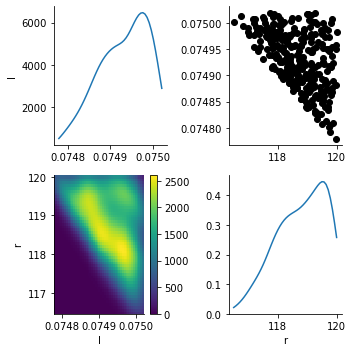

In [10]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w);

## Visualise how the parameters converge over populations

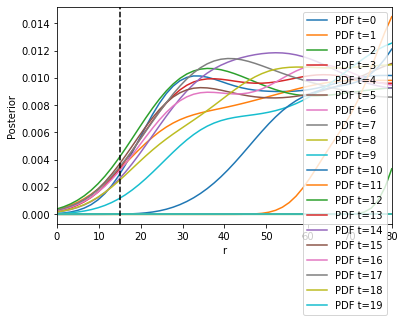

In [11]:
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df,
        w,
        xmin=0,
        xmax=80,
        x="r",
        # xname=r"$\lambda$",
        ax=ax,
        label=f"PDF t={t}",
    )
#Add a vertical line at lambda=0.49 +- 0.32 to 0.72 
#This is the experimental value predicted in King et al. 2020 with Kalanne
ax.axvline(15, color="k", linestyle="dashed")
ax.legend();

# Summary statistics

First some summary statistics and save to file

In [12]:
df.to_csv("abc_results_second_half.csv", encoding='utf-8', index=False)
df.describe()

name,l,r
count,297.000000,297.000000
mean,0.074930,118.679794
std,0.000054,0.755365
min,0.074780,116.497841
25%,0.074891,118.136680
50%,0.074932,118.703511
75%,0.074974,119.273369
max,0.075020,119.998848


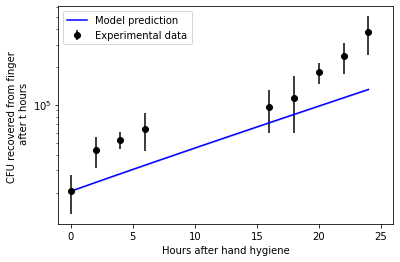

In [13]:
import pandas as pd
import operator
import matplotlib.pyplot as plt
import numpy as np


#plot some curves from the ODE model
initial_contamination=20560
precision=5000
tmax = 24
time_space = np.linspace(0,tmax,precision+1)#precision+1?

#P=odeint(ode_model,initial_contamination,time_space,args=(10,0.125))

P=odeint(ode_model,initial_contamination,time_space,args=(df["r"].mean(),df["l"].mean()))
Pmin=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.05),df["l"].quantile(0.05)))
Pmax=odeint(ode_model,initial_contamination,time_space,args=(df["r"].quantile(0.95),df["l"].quantile(0.95)))

# create a vector of values between 0 and 6
x = np.array([0,2,4,6,16,18,20,22,24])

#Define new sd just for plotting to avoid SD value at 0
#s=np.array([385,93.70165,86.13942,162.11107])
#measurement_data = np.array([1200,134.0,202.0,294.0])
#measurement_data =np.array([20560,43400,52880,64000])
#s=np.array([7482.51295,11958.26074,8100.12346,21478.82678])
#measurement_times = np.array([0,2,4,6]) 
measurement_data =np.array([20560,43400,52880,64000,95600,113600,180800,242800,375600])#  np.array([134.0,202.0,294.0]) #y_observed #
s=np.array([7000,11958,8100,21479,35767,54542,34543,66055,128294])#np.array([93.70165,86.13942,162.11107])#,116.61904,123.61230,396.88789,628.87201,1147.13556]) y_observed_sd #
measurement_times = np.array([0,2,4,6,16,18,20,22,24])


#Plot errobars of experimental data

plt.errorbar(x,measurement_data,yerr=s,fmt='o', color='black',label='Experimental data')

#Plot the model prediction
plt.plot(time_space,P,label="Model prediction",color='blue')

#Plot confidence intervals around the model prediction

plt.fill_between(time_space,np.concatenate(Pmin),np.concatenate(Pmax),alpha=0.2,color='blue')
#plt.plot(time_space,Pmin,label="Model prediction",color='red')
#plt.plot(time_space,Pmax,label="Model prediction",color='red')

#plt.fill_between(x, np.array(map(operator.sub, P["Contamination"], Pmin["Contamination"])), np.array(map(operator.add, P["Contamination"], Pmax["Contamination"])), color='b', alpha=.1)
plt.xlim(-1,26)
plt.ylabel("CFU recovered from finger \n after t hours")
plt.yscale("log")
plt.xlabel("Hours after hand hygiene")
plt.legend(loc="upper left")
#make y axis logarithmic


#save the plot
#plt.savefig("../Images/abc_prediction.png", dpi=600)

plt.show()